In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib
import streamlit as st

In [2]:
# Define the features and lag
features = [
    "temp2_max(c)", "temp2_min(c)", "temp2_ave(c)", 
    "suface_pressure(pa)", "wind_speed50_max(m/s)", "wind_speed50_min(m/s)", 
    "wind_speed50_ave(m/s)", "prectotcorr", "total_demand(mw)"
]
lag = 1

# Load the test data
test_data = pd.read_csv(r"c:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Data\uploaded_test_data.csv", index_col="date", parse_dates=True)

In [3]:

# Directory containing pre-fitted scalers
scalers_dir = r"C:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Notebooks\scalers"

# Dictionary to store predictions and RMSE for each feature
results = {}

model_dir = r"C:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Notebooks\models"

# Loop through each feature
for feature in features:
    # Load the saved model
    model_path = os.path.join(model_dir, f"{feature.replace('/', '')}_LSTM.h5")
    model = load_model(model_path, custom_objects={'mse': mean_squared_error})
    
    # Load the pre-fitted scaler for the current feature
    scaler_path = os.path.join(scalers_dir, f"{feature.replace('/', '')}_scaler.pkl")
    with open(scaler_path, 'rb') as f:
        feature_scaler = joblib.load(f)
    
    # Scale the test data for the current feature using the pre-fitted scaler
    scaled_test_data = feature_scaler.transform(test_data[[feature]].values)
    
    # Create lagged features
    X_test, y_test = [], []
    for i in range(lag, len(scaled_test_data)):
        X_test.append(scaled_test_data[i-lag:i, 0])
        y_test.append(scaled_test_data[i, 0])
    X_test = np.array(X_test).reshape((len(X_test), lag, 1))
    y_test = np.array(y_test).reshape(-1, 1)
    
    # Make predictions
    predictions = model.predict(X_test, verbose=0)
    predictions = feature_scaler.inverse_transform(predictions)
    y_test = feature_scaler.inverse_transform(y_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data[[feature]].iloc[lag:-1], predictions[1:]))
    results[feature] = {"predictions": predictions, "rmse": rmse}

2025-05-11 19:27:49.250 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:52.282 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:53.393 
  command:

    streamlit run c:\Users\Idea\anaconda3\envs\TensorFlow\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-11 19:27:53.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

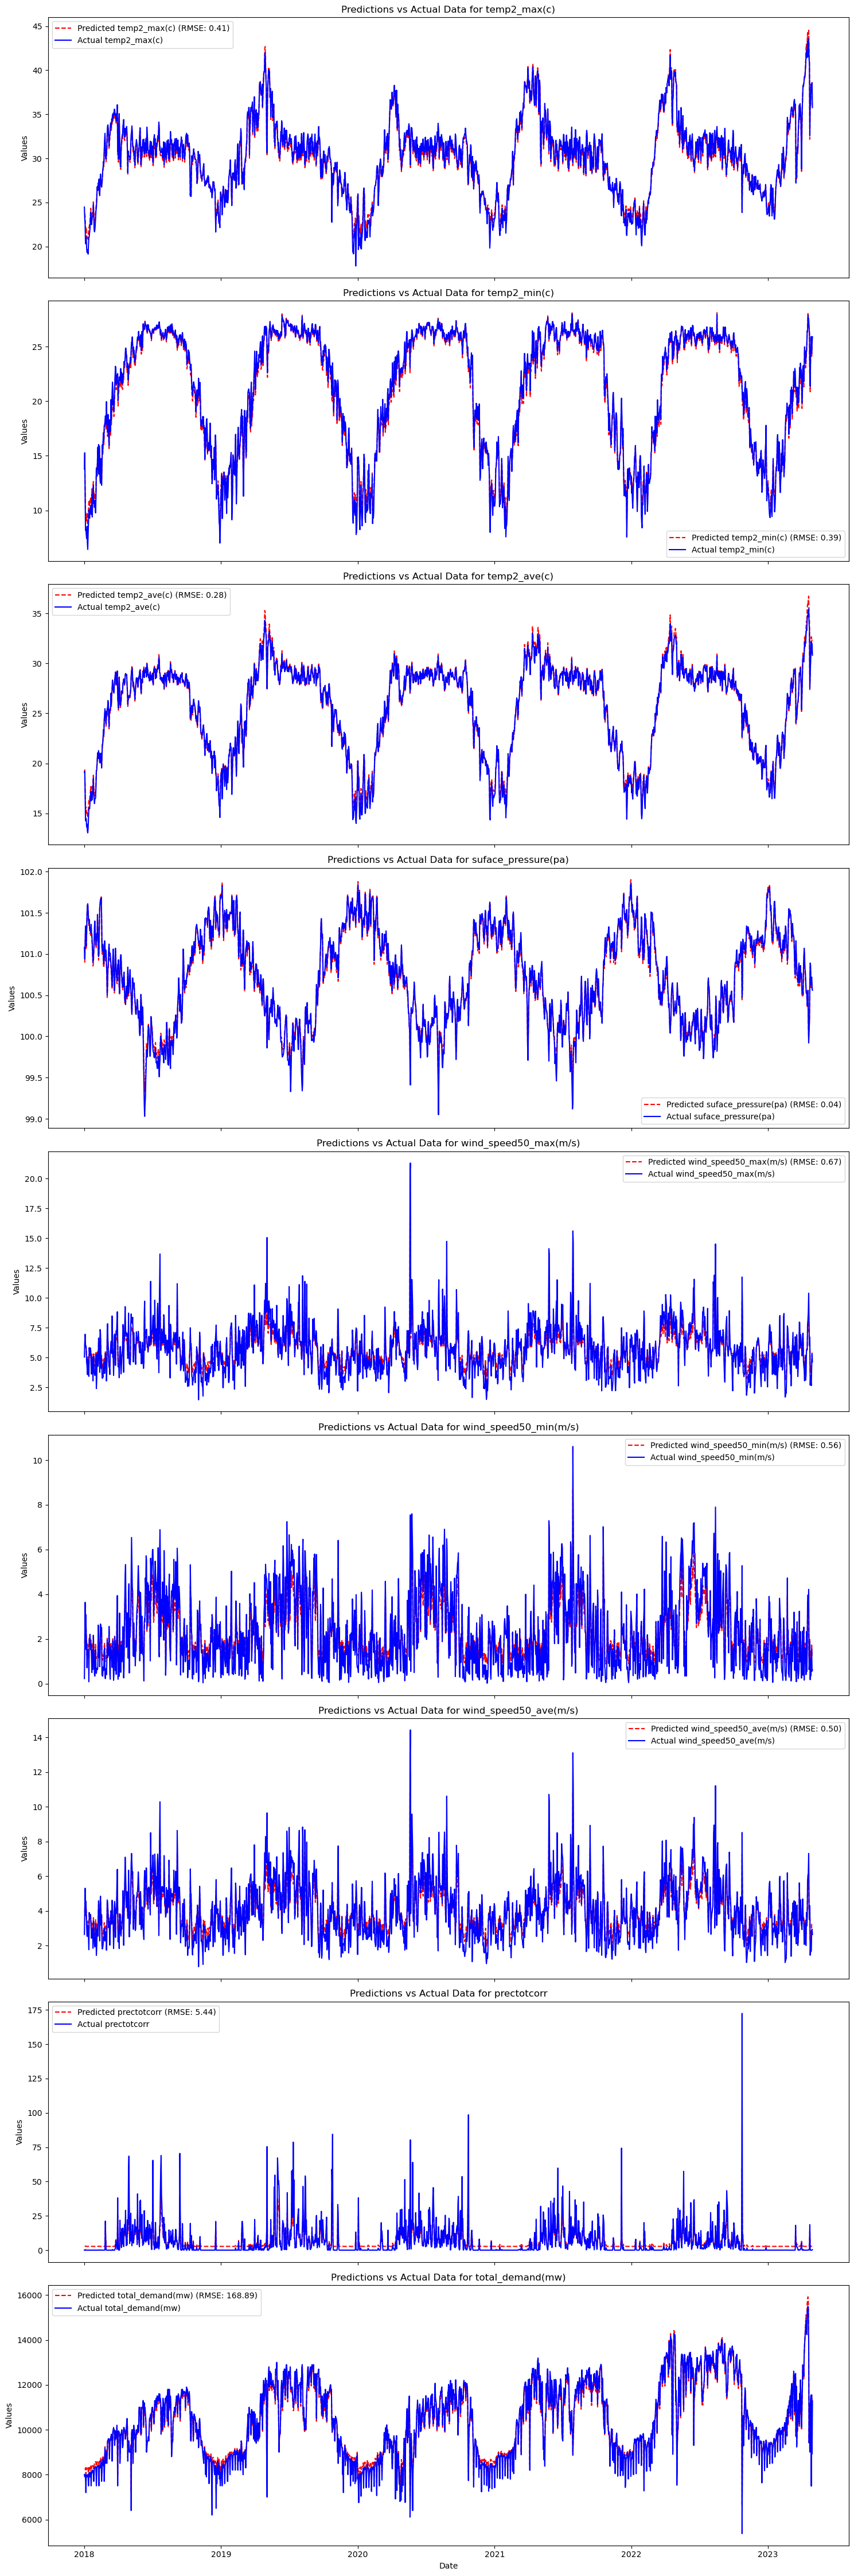

In [4]:
# Plot the predictions for each feature in subplots
fig, axes = plt.subplots(len(features), 1, figsize=(15, 5 * len(features)), sharex=True)

for i, feature in enumerate(features):
    ax = axes[i]
    ax.plot(test_data.index[lag:-1], results[feature]["predictions"][1:], label=f"Predicted {feature} (RMSE: {results[feature]['rmse']:.2f})", color='red', linestyle='--')
    ax.plot(test_data.index, test_data[feature], label=f"Actual {feature}", color='blue')
    ax.set_title(f"Predictions vs Actual Data for {feature}")
    ax.set_ylabel("Values")
    ax.legend()

plt.xlabel("Date")
plt.tight_layout()
st.pyplot(plt.gcf())

In [5]:
# Load the saved model
model = load_model(r"C:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Notebooks\models\final_model 291.19.h5", custom_objects={'mse': mean_squared_error})

# Load the data
test_data = pd.read_csv(r"c:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Data\uploaded_test_data.csv", index_col="date", parse_dates=True)

# Prepare the test data
y_test = test_data["max_generation(mw)"]
X_test = test_data.drop(columns=["total_demand(mw)"])

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers on the training data (you need to ensure the same scaling as the original notebook)
scaler_X=joblib.load("X_train_scaler.pkl")
scaler_y=joblib.load("y_train_scaler.pkl")

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape X_test_scaled to match the expected input shape
n_input = 1  # Same as defined in the original notebook
n_features = X_test.shape[1]
X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], n_input, n_features))

# Predict and inverse transform the predictions
y_pred_scaled = model.predict(X_test_scaled_reshaped, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(test_data.index, test_data["max_generation(mw)"], label="Actual", color="blue")
plt.plot(test_data.index, y_pred, label="Prediction", color="red")
plt.xlabel("Date")
plt.ylabel("Max Generation (MW)")
plt.title("Actual vs Predicted Max Generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
st.pyplot(plt.gcf())

2025-05-11 19:27:55.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:55.519 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:55.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [6]:
# Cell to replace (cell #2a305dff)

# Create a DataFrame for predictions
pred_data = pd.DataFrame(index=test_data.index[lag:])  # Adjust index to match the length of predictions

# Add predictions for each feature to the DataFrame - with proper dimension checking
for feature in features:
    pred_values = results[feature]["predictions"].flatten()
    
    # Check if dimensions match, and resize if necessary
    if len(pred_values) != len(pred_data):
        # Use only the first len(pred_data) values
        pred_values = pred_values[:len(pred_data)]
        print(f"Warning: Resized predictions for {feature} to match DataFrame index length")
    
    pred_data[feature] = pred_values

In [7]:
# Générer un vecteur booléen où la condition est vérifiée
JoursAssurés = (test_data["max_generation(mw)"].values[1:] - test_data["total_demand(mw)"].values[:-1]) > 1
len(JoursAssurés)

1945

In [8]:
# Transform y_pred from shape (379, 1) to (379,)
y_pred = y_pred.reshape(-1)

In [9]:
JoursAssurésPredit = (y_pred[1:] - pred_data["total_demand(mw)"].values) > 1
len(JoursAssurésPredit)

1945

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["max_generation(mw)"], label="Actual Max Generation (MW)", color="blue")
plt.plot(test_data.index, y_pred, label="Predicted Max Generation (MW)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Max Generation (MW)")
plt.title("Actual vs Predicted Max Generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
st.pyplot(plt.gcf())

2025-05-11 19:27:55.641 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:56.008 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:56.009 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(pred_data.index[:-1], pred_data["total_demand(mw)"][1:], label="Predicted Total Demand (MW)", color="red", linestyle="--")
plt.plot(test_data.index, test_data["total_demand(mw)"], label="Actual Total Demand (MW)", color="blue")
plt.xlabel("Date")
plt.ylabel("Total Demand (MW)")
plt.title("Predicted vs Actual Total Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
st.pyplot(plt.gcf())

2025-05-11 19:27:56.066 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:56.416 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 19:27:56.417 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [12]:
len(test_data.index[lag:])

1945

In [13]:
len(y_pred[lag:])

1945

In [14]:
len(test_data)

1946

In [15]:
results["total_demand(mw)"]["predictions"].flatten()

array([ 8304.494,  8230.858,  8230.858, ...,  7934.932, 11398.862,
        9013.236], dtype=float32)

In [16]:
# Créer un DataFrame pour les prédictions de génération et de consommation
results_df = pd.DataFrame({
    "date": test_data.index[lag:],  # Utiliser les dates correspondantes
    "generation_predite": y_pred[lag:],  # Prédictions de génération
    "consommation_predite": results["total_demand(mw)"]["predictions"].flatten()  # Consommation réelle
})

# Sauvegarder les résultats dans un fichier CSV
results_path = r"c:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Notebooks\results.csv"
results_df.to_csv(results_path, index=False)
print(f"✅ Résultats sauvegardés dans {results_path}")

✅ Résultats sauvegardés dans c:\Users\Idea\Documents\Programming languages\Python\Notebooks\Time Series\Project_1\Notebooks\results.csv
